In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
data_dir = d2l.download_extract('hotdog')

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=224),
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor(),
    normalize
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=224), 
    torchvision.transforms.ToTensor(),
    normalize
])


finetune_net = torchvision.models.resnet18(weights='DEFAULT')
#  print(finetune_net.fc)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)


Parameter containing:
tensor([[-0.0074,  0.0024,  0.0693,  ..., -0.0865,  0.0810, -0.0492],
        [-0.0811, -0.0646, -0.0603,  ..., -0.0358, -0.0398, -0.0343]],
       requires_grad=True)

In [3]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_set = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs)
    valid_set = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    valid_iter = torch.utils.data.DataLoader(valid_set, batch_size, shuffle=False)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        params_1x = [ param for name, param in net.named_parameters() if name not in ['fc.weight', 'fc.bias'] ]
        trainer = torch.optim.SGD(
            [
                {'params': params_1x}, 
                {'params': net.fc.parameters(), 'lr': learning_rate * 10} 
            ],
            lr=learning_rate, weight_decay=0.001
        )
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, valid_iter, loss, trainer, num_epochs, devices)


RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 1.96 GiB total capacity; 1.30 GiB already allocated; 2.06 MiB free; 1.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

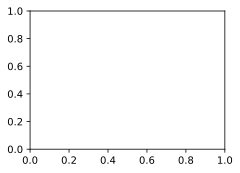

In [4]:
train_fine_tuning(finetune_net, learning_rate=5e-5)